In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import Tool
import numpy as np
import tqdm
import tejapi
from datetime import datetime, timedelta

In [3]:
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['font.family'] = 'Microsoft JhengHei' 
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('ggplot')

In [4]:
twse = tejapi.get('TWN/APIPRCD', coid='IX0001',opts={'columns': ['mdate','roi','close_d','vol','low_d','open_d','high_d','turnover']}, mdate={'gte': '2010-01-01', 'lte':'2025-04-22'}, paginate=True)

In [5]:
twse['roi'] = (twse['roi'] / 100).shift(-2)
twse.set_index('mdate', inplace=True)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
mpl.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('ggplot')
import warnings
warnings.filterwarnings("ignore")

In [7]:
close_df = twse.rename(columns={
    "open_d": "open",
    "high_d": "high",
    "low_d": "low",
    "close_d": "close",
    "vol": "volume",
    'turnover': 'turnover_rate_f'
})

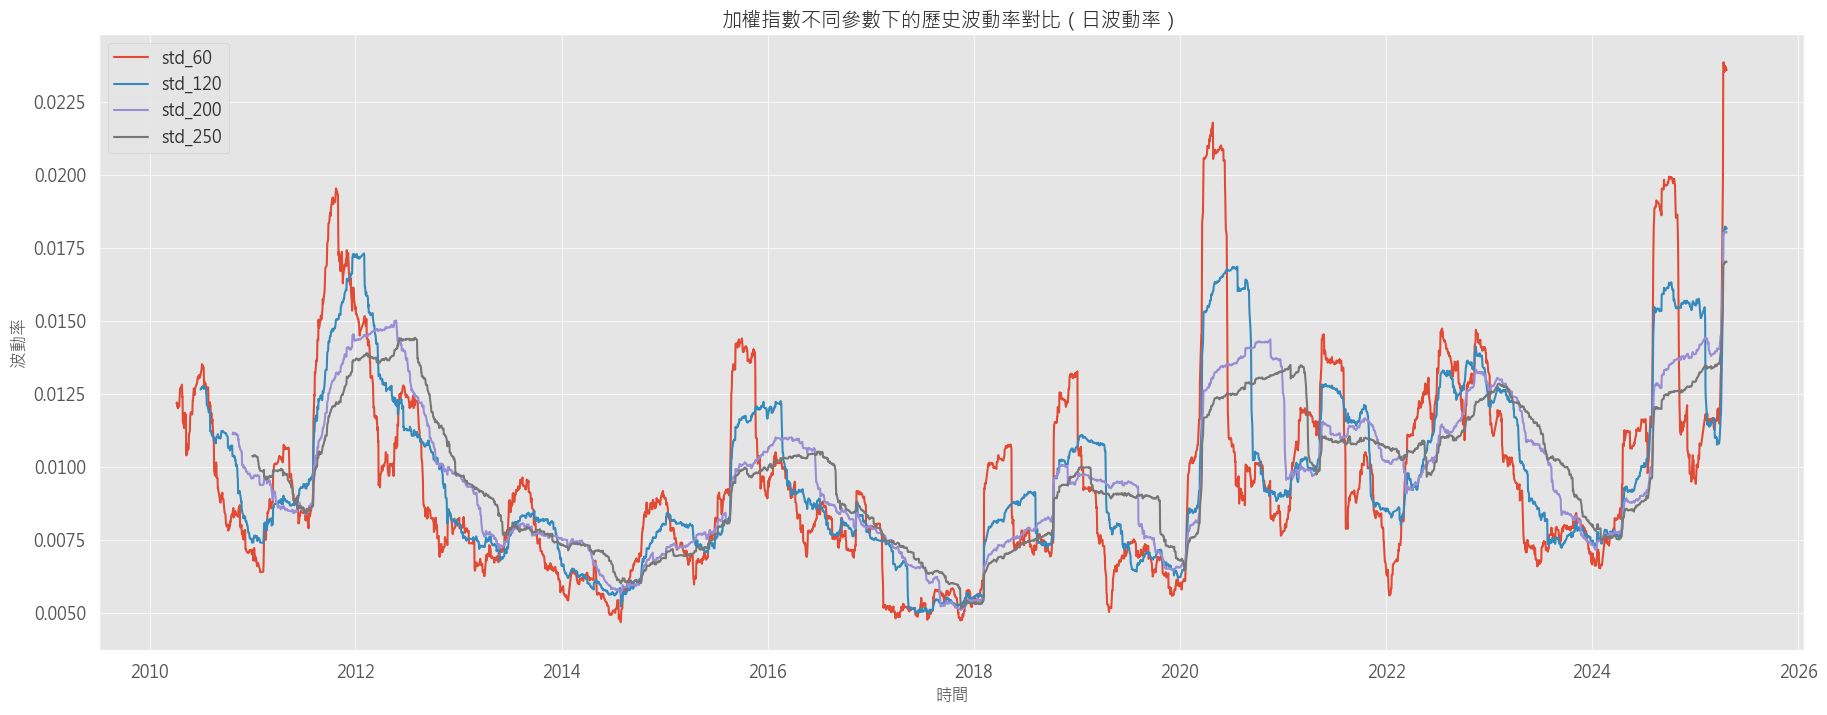

In [8]:
close_df['pre_close'] = close_df['close'].shift(1) 
close_df['pct'] = close_df['close']/close_df['pre_close']-1

plt.figure(figsize=(22, 8))
# 未年化
for periods in [60, 120, 200, 250]:

    col = 'std_'+str(periods)
    close_df[col] = close_df['pct'].rolling(periods).std()
    plt.plot(close_df[col], label=col)

plt.legend(loc='best')
plt.xlabel('時間')
plt.ylabel('波動率')
plt.title('加權指數不同參數下的歷史波動率對比（日波動率）')
plt.show()

# 長期波動率

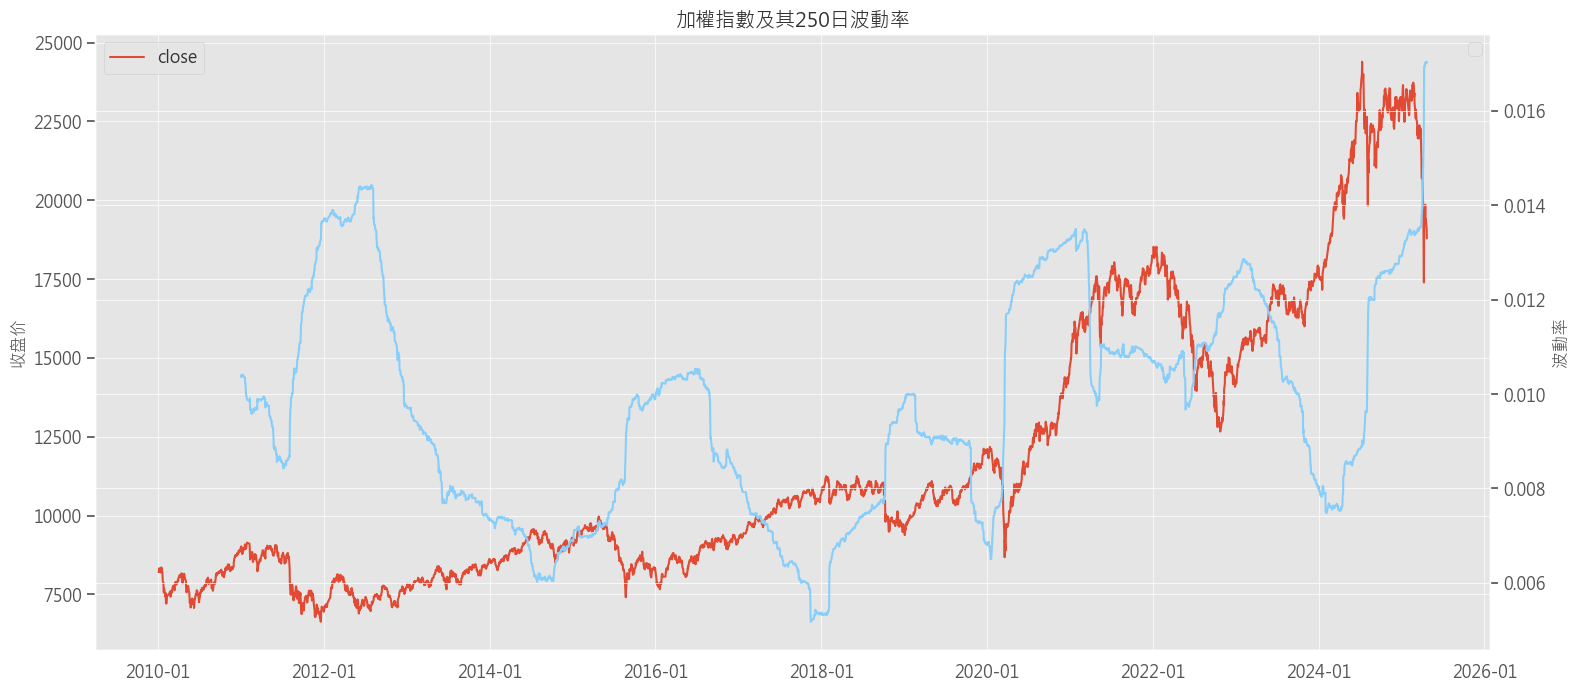

In [9]:
y1 = close_df['close']  
y2 = close_df['std_250']  

fig = plt.figure(figsize=(18, 8))  

ax1 = fig.add_subplot(111)

ax1.plot(y1, label='close')
ax1.set_ylabel('收盘价')
plt.legend(loc='upper left')


ax2 = ax1.twinx()  
ax2.plot(y2, '#87CEFA')
ax2.set_ylabel('波動率')
plt.legend(loc='best')

ax1.set_title("加權指數及其250日波動率")
ax1.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m')) 
plt.xlabel('時間')
plt.show()

# rolling corr

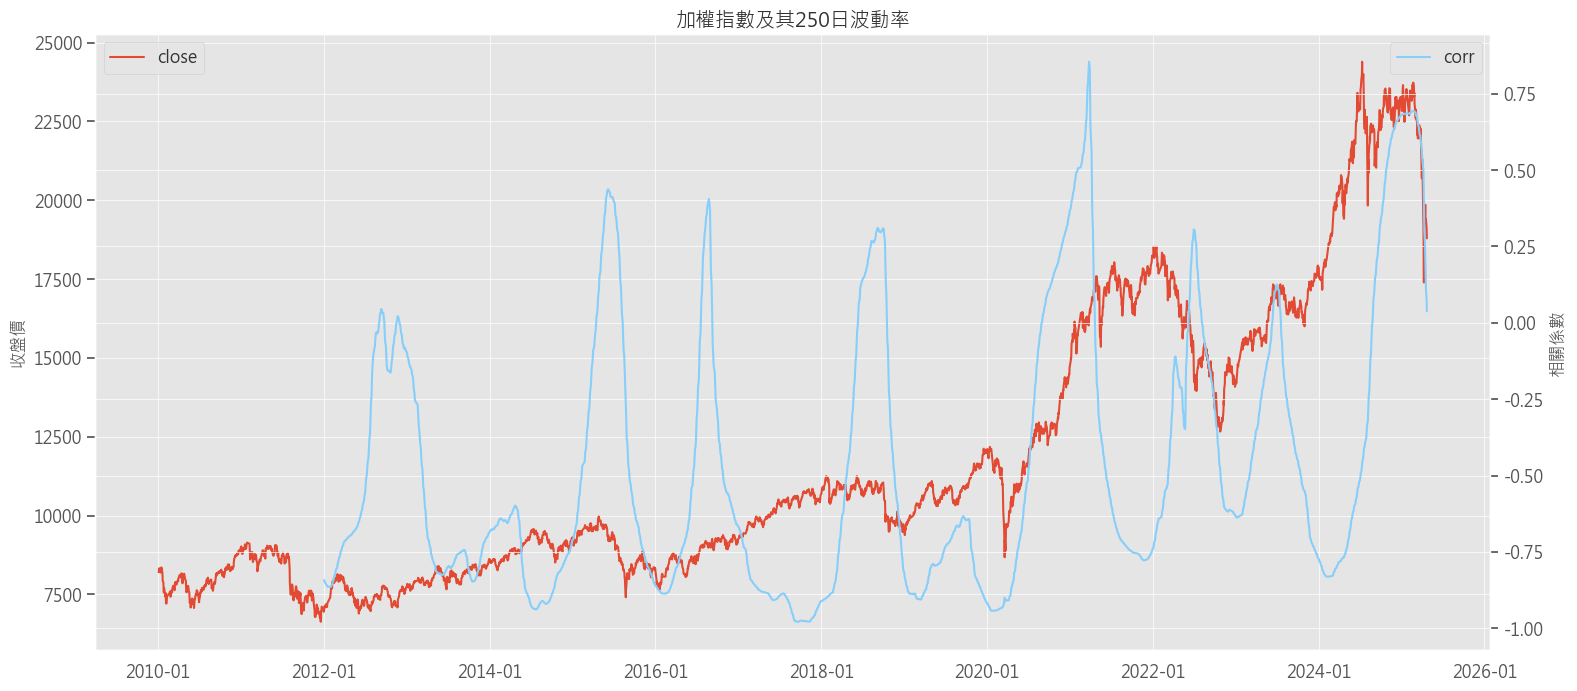

In [10]:
y1 = close_df['close'] 
y2 = close_df['close'].rolling(250).corr(close_df['std_250']) 

fig,ax = plt.subplots(1,1,figsize=(18,8)) 


ax.plot(y1,label='close') 
ax.set_ylabel('收盤價')
plt.legend(loc='upper left')

ax1 = ax.twinx()  
ax1.plot(y2,'#87CEFA',label='corr')
ax1.set_ylabel('相關係數')
plt.legend(loc='upper right')

ax1.set_title("加權指數及其250日波動率")
ax1.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m')) 
plt.xlabel('时间')
plt.show()

# turnover

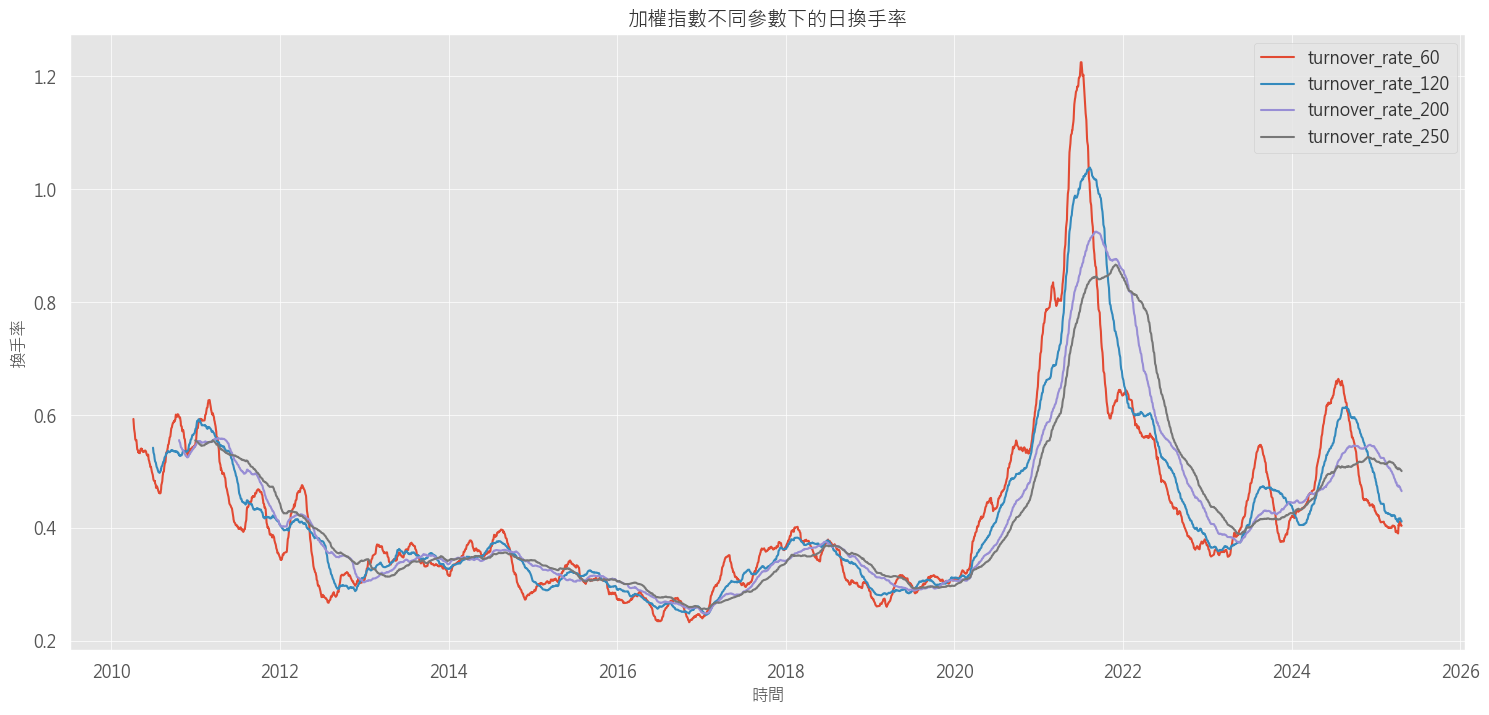

In [11]:
plt.figure(figsize=(18, 8))

for periods in [60, 120, 200, 250]:

    col = 'turnover_rate_'+str(periods)
    close_df[col] = close_df['turnover_rate_f'].rolling(
        periods).mean()
    plt.plot(close_df[col], label=col)

plt.legend(loc='best')
plt.xlabel('時間')
plt.ylabel('換手率')
plt.title('加權指數不同參數下的日換手率')
plt.show()

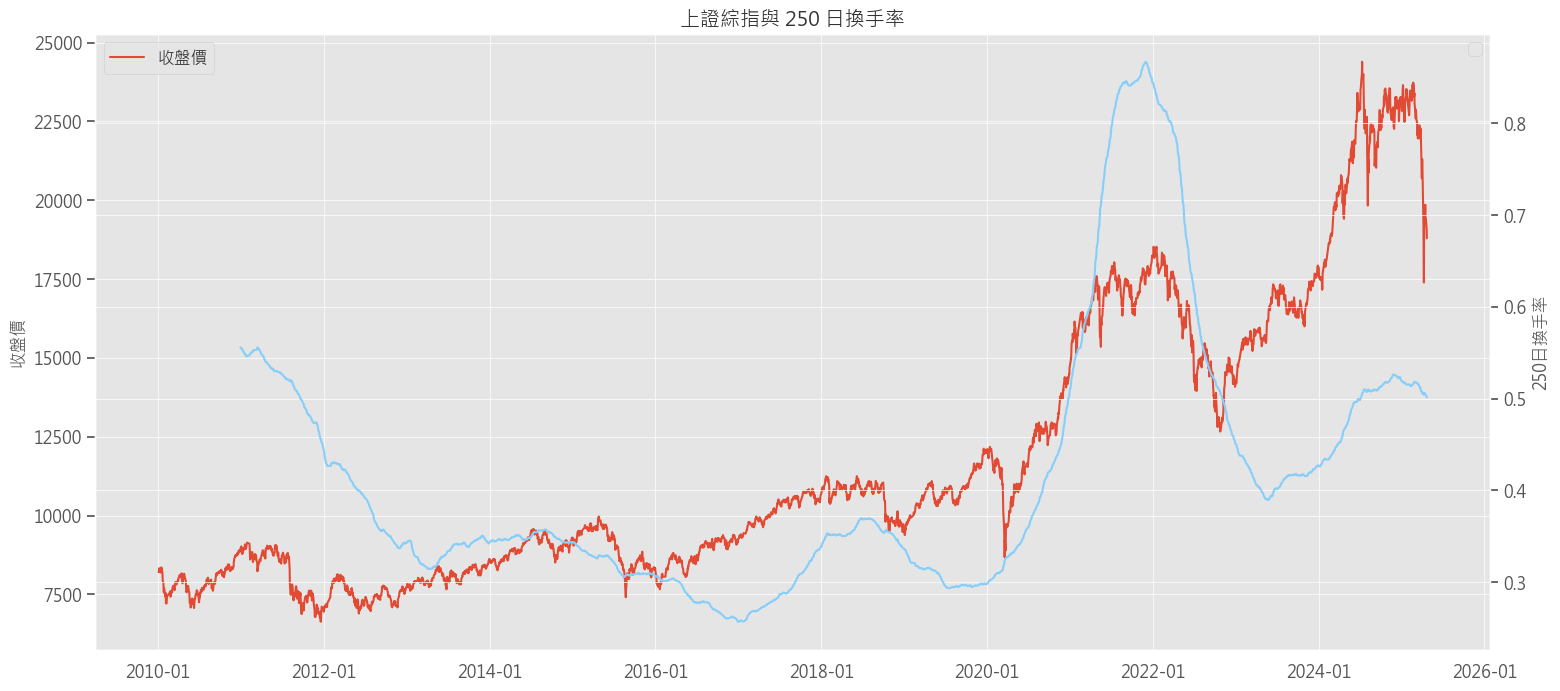

In [12]:
close_df['turnover_rate_250'] = close_df['turnover_rate_250']
y1 = close_df['close'] 
y2 = close_df['turnover_rate_250']  

fig = plt.figure(figsize=(18, 8)) 

ax1 = fig.add_subplot(111)

ax1.plot(y1, label='收盤價')
ax1.set_ylabel('收盤價')
plt.legend(loc='upper left')

ax2 = ax1.twinx()  
ax2.plot(y2, '#87CEFA')
ax2.set_ylabel('250日換手率')
plt.legend(loc='best')

ax1.set_title("上證綜指與 250 日換手率")
ax1.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))  
plt.xlabel('時間')
plt.show()


# describe

In [13]:
print('波動率:\n', (close_df['std_250']*100).describe(), '\n')

print('換手率\n', close_df['turnover_rate_250'].describe())

波動率:
 count    3500.000000
mean        0.968258
std         0.231675
min         0.517037
25%         0.763268
50%         0.967325
75%         1.130747
max         1.704198
Name: std_250, dtype: float64 

換手率
 count    3501.000000
mean        0.416115
std         0.141278
min         0.256964
25%         0.319472
50%         0.354824
75%         0.490040
max         0.866978
Name: turnover_rate_250, dtype: float64


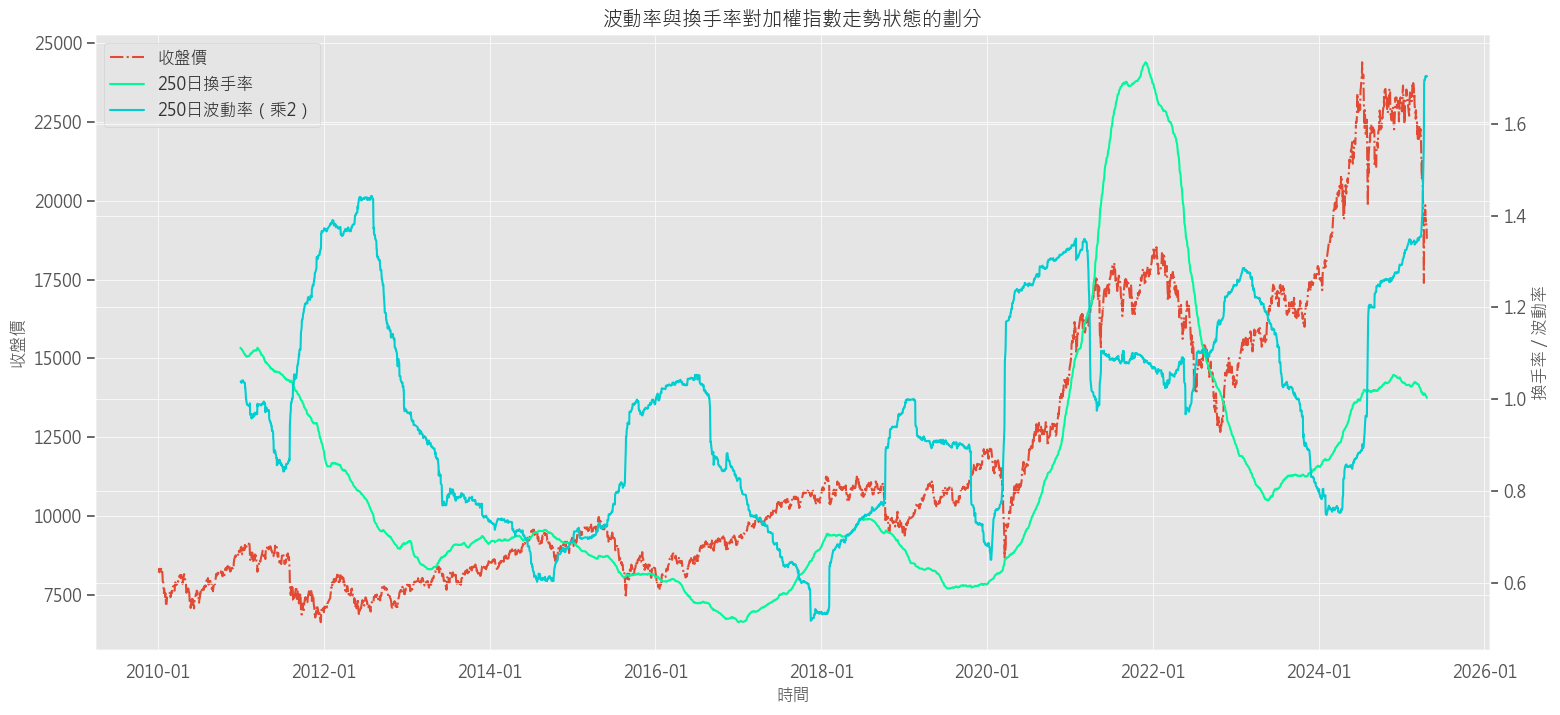

In [14]:
y1 = close_df['close']  
y2 = close_df['turnover_rate_250'] * 2  # 250日換手率 乘以二是比較好比較
y3 = close_df['std_250'] * 100# 250日年化波動率

fig = plt.figure(figsize=(18, 8))  

ax1 = fig.add_subplot(111)
ax1.plot(y1, linestyle='-.', label='收盤價')
ax1.set_ylabel('收盤價')
ax1.set_title("波動率與換手率對加權指數走勢狀態的劃分")
ax1.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m')) 
plt.xlabel('時間')

ax2 = ax1.twinx()  
ax2.plot(y2, color='#00FA9A', label='250日換手率')
ax2.plot(y3, color='#00CED1', label='250日波動率（乘2）')
ax2.set_ylabel('換手率 / 波動率')

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.show()


# 牛熊指標建構

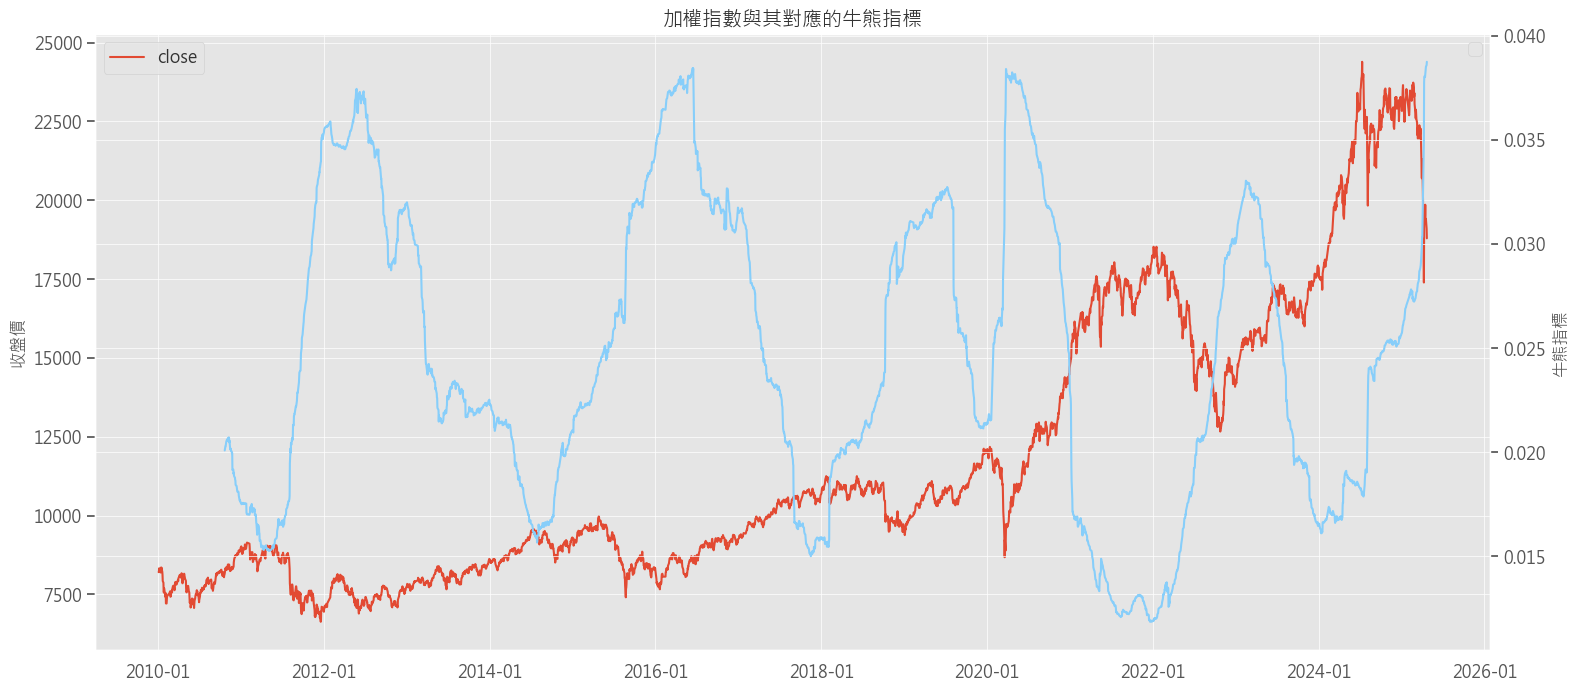

In [15]:
close_df['kernel_index'] = close_df['std_200'] / \
    close_df['turnover_rate_200']

y1 = close_df['close']  
y2 = close_df['kernel_index']  

fig = plt.figure(figsize=(18, 8)) 
ax1 = fig.add_subplot(111)

ax1.plot(y1, label='close')
ax1.set_ylabel('收盤價')
plt.legend(loc='upper left')


ax2 = ax1.twinx()  
ax2.plot(y2, '#87CEFA')
ax2.set_ylabel('牛熊指標')
plt.legend(loc='best')

ax1.set_title("加權指數與其對應的牛熊指標")
ax1.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))  
plt.xlabel('时间')
plt.show()

### 
可看出呈明顯的反向關係

In [16]:
corr = close_df[['kernel_index']].corrwith(close_df['close']).values[0]
print('牛熊指標與大盤的相關性:%.2f' % corr)

牛熊指標與大盤的相關性:-0.35


In [17]:
from src.vt import VT_Factor
from src.backtest_engine import *

# 均線

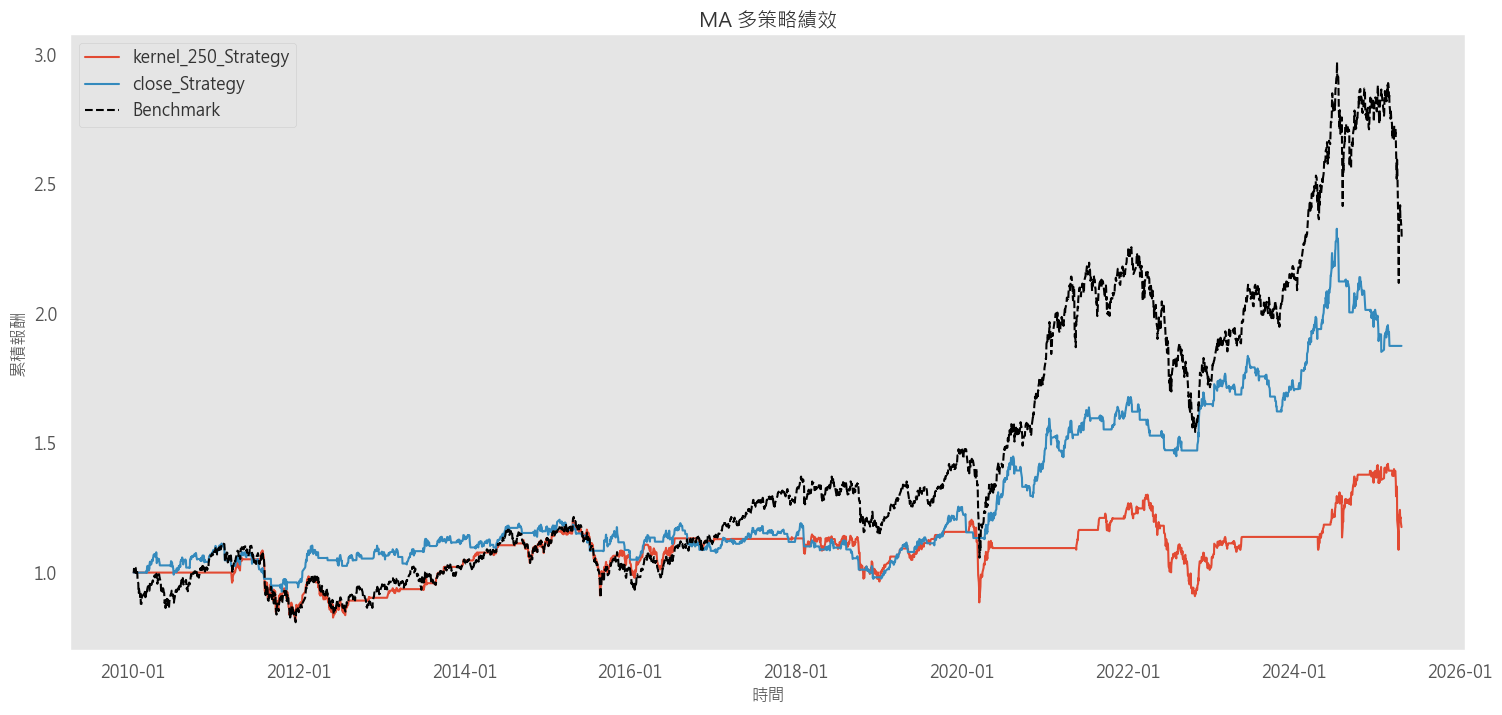


=== 策略參數: kernel_250 ===
年化報酬率: 0.05%
累積報酬率: 1.04%
夏普比率: 0.48
最大回撤: 0.28%
持倉總天數: 2354
交易次數: 36
平均持倉天數: 65.39
獲利天數: 1273
虧損天數: 1081
勝率(按天): 0.54%
平均獲利率(按天): 0.01%
平均虧損率(按天): -0.01%
平均盈虧比(按天): 1.18
獲利次數: 19
虧損次數: 17
單次最大獲利: 0.26%
單次最大虧損: -0.11%
勝率(按次): 0.53%
平均獲利率(按次): 0.04%
平均虧損率(按次): -0.02%
平均盈虧比(按次): 1.12

=== 策略參數: close ===
年化報酬率: 0.05%
累積報酬率: 1.04%
夏普比率: 0.48
最大回撤: 0.28%
持倉總天數: 2354
交易次數: 36
平均持倉天數: 65.39
獲利天數: 1273
虧損天數: 1081
勝率(按天): 0.54%
平均獲利率(按天): 0.01%
平均虧損率(按天): -0.01%
平均盈虧比(按天): 1.18
獲利次數: 19
虧損次數: 17
單次最大獲利: 0.26%
單次最大虧損: -0.11%
勝率(按次): 0.53%
平均獲利率(按次): 0.04%
平均虧損率(按次): -0.02%
平均盈虧比(按次): 1.12


In [35]:
vt = VT_Factor(close_df, periods=250)
signal_df = vt.get_signal()

#（以 kernel_250 + close 為均線策略）
bt = BacktestEngine(signal_df, ['kernel_250', 'close'], method='MA')
bt.plot_net_value()
bt.summary()

# 布林

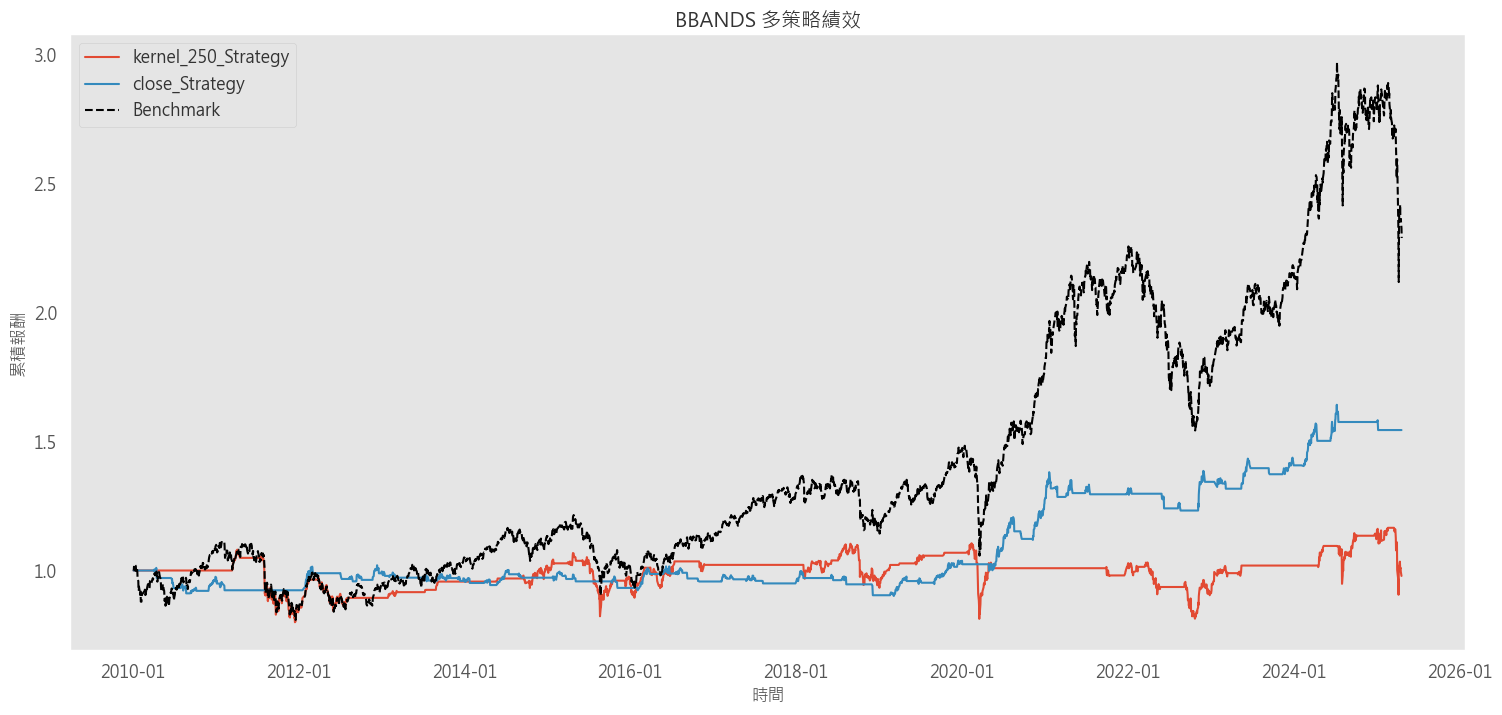


=== 策略參數: kernel_250 ===
年化報酬率: -0.00%
累積報酬率: -0.02%
夏普比率: 0.05
最大回撤: 0.27%
持倉總天數: 1324
交易次數: 35
平均持倉天數: 37.83
獲利天數: 717
虧損天數: 606
勝率(按天): 0.54%
平均獲利率(按天): 0.01%
平均虧損率(按天): -0.01%
平均盈虧比(按天): 1.18
獲利次數: 22
虧損次數: 13
單次最大獲利: 0.08%
單次最大虧損: -0.16%
勝率(按次): 0.63%
平均獲利率(按次): 0.02%
平均虧損率(按次): -0.02%
平均盈虧比(按次): 1.69

=== 策略參數: close ===
年化報酬率: 0.03%
累積報酬率: 0.54%
夏普比率: 0.47
最大回撤: 0.12%
持倉總天數: 1113
交易次數: 63
平均持倉天數: 17.67
獲利天數: 610
虧損天數: 503
勝率(按天): 0.55%
平均獲利率(按天): 0.01%
平均虧損率(按天): -0.01%
平均盈虧比(按天): 1.21
獲利次數: 26
虧損次數: 37
單次最大獲利: 0.16%
單次最大虧損: -0.05%
勝率(按次): 0.41%
平均獲利率(按次): 0.02%
平均虧損率(按次): -0.01%
平均盈虧比(按次): 0.70


In [19]:
vt = VT_Factor(close_df, periods=250)
signal_df = vt.get_signal()

#（以 kernel_250 + close 為布林策略）
bt = BacktestEngine(signal_df, ['kernel_250', 'close'], method='BBANDS')
bt.plot_net_value()
bt.summary()

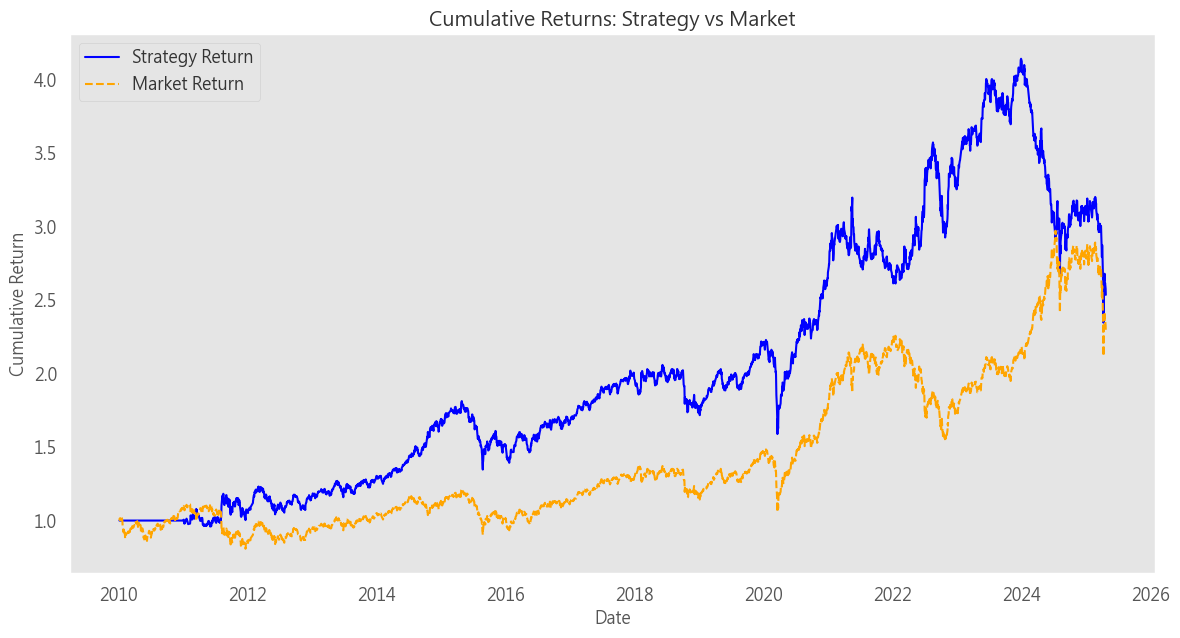

Total Return: 153.54%
Annualized Return: 6.45%
Sharpe Ratio: 0.47
Max Drawdown: -43.35%


In [ ]:
upper_threshold = signal_df['kernel_250'].quantile(0.8)  
lower_threshold = signal_df['kernel_250'].quantile(0.2)  

# 根據 kernel_250 生成交易信號
signal_df['position'] = 0
signal_df.loc[signal_df['kernel_250'] < upper_threshold, 'position'] = -1  # 空頭
signal_df.loc[signal_df['kernel_250'] > lower_threshold, 'position'] = 1   # 多頭

signal_df['daily_return'] = signal_df['close'].pct_change()
signal_df['strategy_return'] = signal_df['position'].shift(1) * signal_df['daily_return']
signal_df['cumulative_strategy_return'] = (1 + signal_df['strategy_return'].fillna(0)).cumprod()
signal_df['cumulative_market_return'] = (1 + signal_df['daily_return'].fillna(0)).cumprod()

plt.figure(figsize=(14, 7))
plt.plot(signal_df['cumulative_strategy_return'], label='Strategy Return', color='blue')
plt.plot(signal_df['cumulative_market_return'], label='Market Return', color='orange', linestyle='--')
plt.title('Cumulative Returns: Strategy vs Market')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()
plt.show()

def show_performance(df):
    total_return = df['cumulative_strategy_return'].iloc[-1] - 1
    annualized_return = (1 + total_return) ** (252 / len(df)) - 1
    sharpe_ratio = df['strategy_return'].mean() / df['strategy_return'].std() * np.sqrt(252)
    max_drawdown = (df['cumulative_strategy_return'] / df['cumulative_strategy_return'].cummax() - 1).min()

    print(f"Total Return: {total_return:.2%}")
    print(f"Annualized Return: {annualized_return:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Max Drawdown: {max_drawdown:.2%}")

show_performance(signal_df)


平均數 : 0.0246
中位數 : 0.0242
標準差 : 0.0066
偏態   : 0.0774
峰度   : -0.9486
+1 標準差 : 0.0311
-1 標準差 : 0.0180
最小值 : 0.0125
最大值 : 0.0383



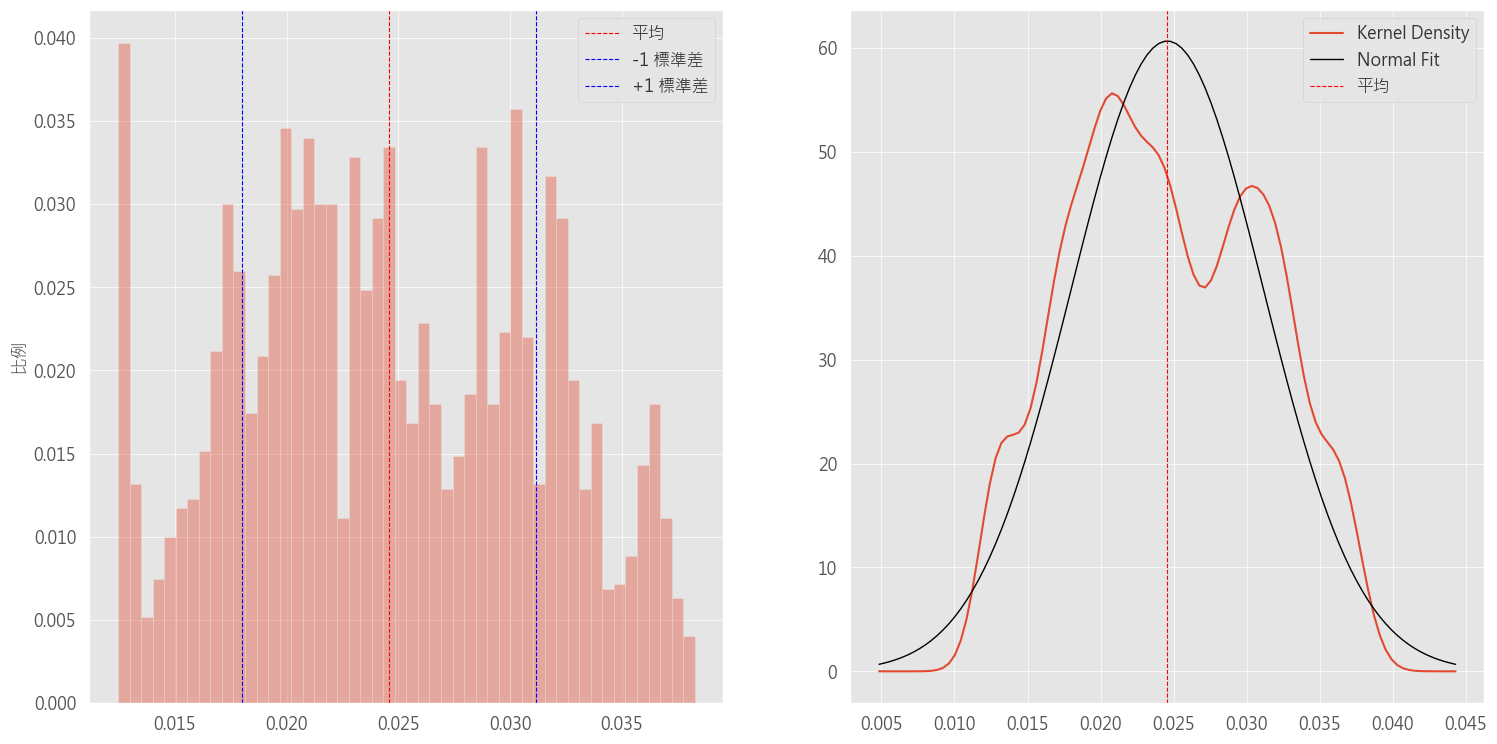


平均數 : 0.0246
中位數 : 0.0242
標準差 : 0.0066
偏態   : 0.0774
峰度   : -0.9486
+1 標準差 : 0.0311
-1 標準差 : 0.0180
最小值 : 0.0125
最大值 : 0.0383



In [54]:
Data_Distribution_Plot(signal_df, 'kernel_250')
Statistical_indicator(signal_df, 'kernel_250')

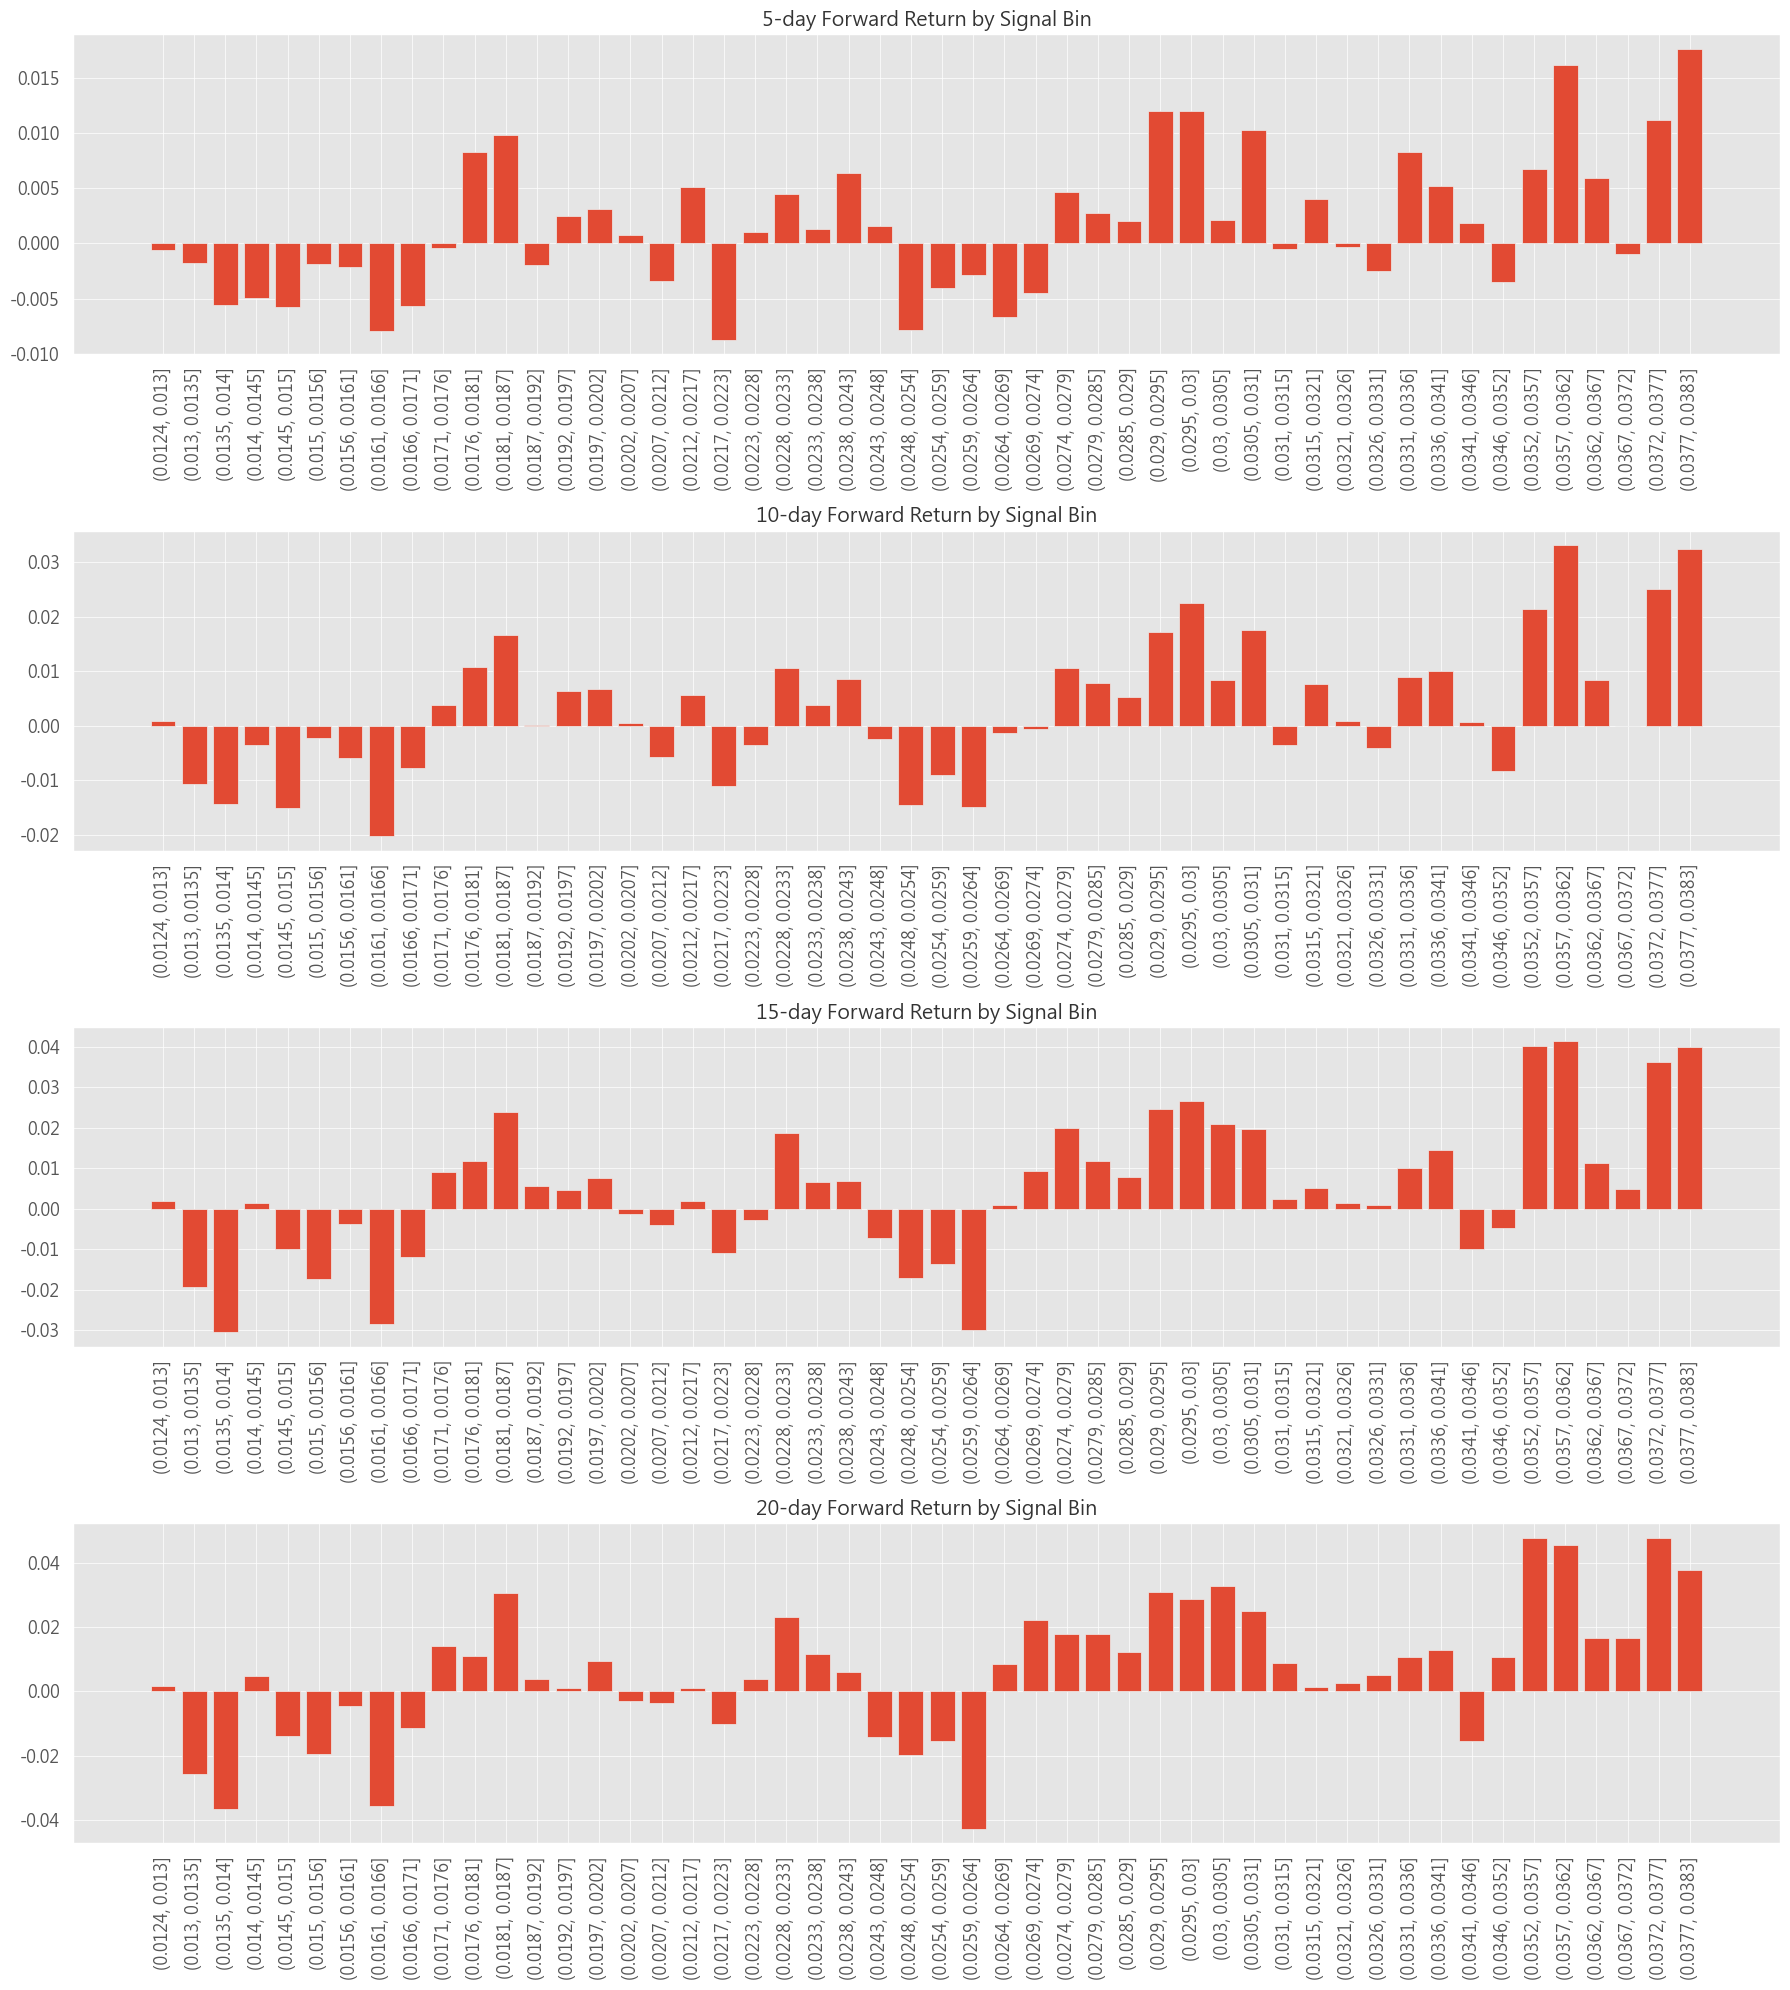

In [55]:
vt.forward_distribution_plot(250, bins=50)

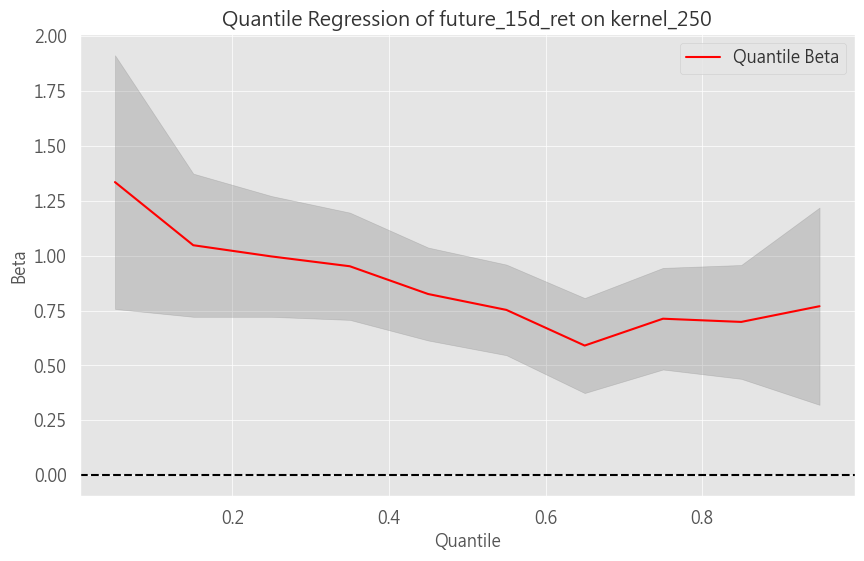

In [56]:
vt.QuantReg_plot()

# 敏感性

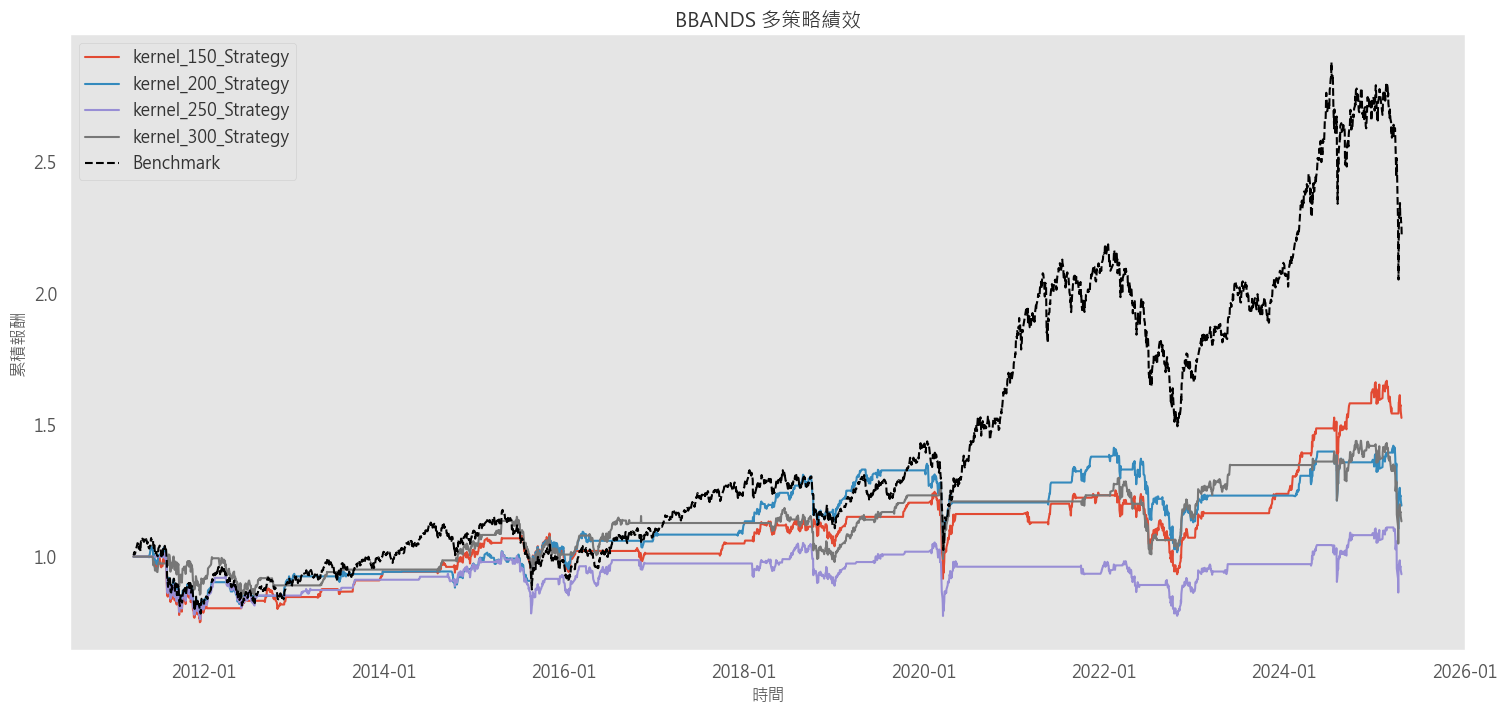


=== 策略參數: kernel_150 ===
年化報酬率: 0.07%
累積報酬率: 1.43%
夏普比率: 0.47
最大回撤: 0.43%
持倉總天數: 2118
交易次數: 9
平均持倉天數: 235.33
獲利天數: 1849
虧損天數: 1600
勝率(按天): 0.87%
平均獲利率(按天): 0.01%
平均虧損率(按天): -0.01%
平均盈虧比(按天): 1.16
獲利次數: 6
虧損次數: 3
單次最大獲利: 0.47%
單次最大虧損: -0.17%
勝率(按次): 0.67%
平均獲利率(按次): 0.13%
平均虧損率(按次): -0.02%
平均盈虧比(按次): 2.00

=== 策略參數: kernel_200 ===
年化報酬率: 0.07%
累積報酬率: 1.43%
夏普比率: 0.47
最大回撤: 0.43%
持倉總天數: 2118
交易次數: 9
平均持倉天數: 235.33
獲利天數: 1849
虧損天數: 1600
勝率(按天): 0.87%
平均獲利率(按天): 0.01%
平均虧損率(按天): -0.01%
平均盈虧比(按天): 1.16
獲利次數: 6
虧損次數: 3
單次最大獲利: 0.47%
單次最大虧損: -0.17%
勝率(按次): 0.67%
平均獲利率(按次): 0.13%
平均虧損率(按次): -0.02%
平均盈虧比(按次): 2.00

=== 策略參數: kernel_250 ===
年化報酬率: 0.07%
累積報酬率: 1.43%
夏普比率: 0.47
最大回撤: 0.43%
持倉總天數: 2118
交易次數: 9
平均持倉天數: 235.33
獲利天數: 1849
虧損天數: 1600
勝率(按天): 0.87%
平均獲利率(按天): 0.01%
平均虧損率(按天): -0.01%
平均盈虧比(按天): 1.16
獲利次數: 6
虧損次數: 3
單次最大獲利: 0.47%
單次最大虧損: -0.17%
勝率(按次): 0.67%
平均獲利率(按次): 0.13%
平均虧損率(按次): -0.02%
平均盈虧比(按次): 2.00

=== 策略參數: kernel_300 ===
年化報酬率: 0.07%
累積報酬率: 1.43%
夏普比率: 0.47
最大回撤: 0.43%
持倉總天

In [57]:
periods = [150, 200, 250, 300]
signal_name = ['kernel_' + str(x) for x in periods]
signal_df = add_all_kernel(signal_df, periods)

filter_nan = signal_df['kernel_' + str(max(periods))].isna().sum()
slice_df = signal_df.iloc[filter_nan:]

BacktestEngine(slice_df, signal_name, method='BBANDS').plot_net_value()
BacktestEngine(slice_df, signal_name, method='BBANDS').summary()